Dataset: You will work with an artificially generated dataset, consisting of 2000 samples, 400 input 
variables and two output variables called class and output. All input variables are standard-scaled 
real numbers. The class variable is discrete and has two possible values - 0 and 1. The other output 
variable is also a real number. Both output variables have non-trivial dependency on some of  the 
input variables. Your task is to build ML models predicting the output variables based on the input 
variables and analyze the dataset, your models and the nature of the dependencies you uncovered.  
 
Desired output: You are supposed to submit Jupyter notebook with the solutions, commentary, 
and results by Moodle. Please make sure your notebook opens and works in Google Colab, it will 
not be graded otherwise. Your solutions will be graded by lab assistants of respective groups.Your 
solution should include a function that can process a “validation_data.csv” file with the same 
structure as your training data and compute the classification accuracies and R^2 values on 
these data for both your baseline and best models (in total 4 numbers). 

In [136]:
import pandas as pd

file = 'zad2_wum_data_for_students.csv'

df = pd.read_csv(file, sep=';')

Task 1. Building baseline models (6 points: 3 for regression + 3 for classification) Given the 
dataset, you should  build baseline models using linear regression and logistic regression for 
output and class variables respectively using all input variables as predictors, without any 
pre-processing (such as dimensionality reduction). Assess their performance on the training data 
and estimate their ability to generalize beyond training data by one of the methods you have 
learned in our lectures.  Comment on the results.

In [137]:
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def baseline_models(df):
    """
    Calculate baseline models for the given DataFrame.
    
    Parameters:
    df (DataFrame): The input DataFrame containing the data.
    
    Returns:
    results (dict): A dictionary containing the R^2 score for linear regression and accuracy for logistic regression.
    """
    
    # linear regression
    results = {}

    Y = df['Output']
    X = df.copy()
    X.drop(columns=['Output', 'Class'], inplace=True)

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
    model = LinearRegression()
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    r2 = r2_score(Y_test, Y_pred)

    results['baseline_r^2'] = r2

    Y = df['Class']
    X = df.copy()
    X.drop(columns=['Class', 'Output'], inplace=True)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
    model = LogisticRegression()
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    accuracy = accuracy_score(Y_test, Y_pred)
    
    results['baseline_accuracy'] = accuracy
    return results

baseline_models(df)


{'baseline_r^2': 0.4463990746888592, 'baseline_accuracy': 0.5175}

Results:

The baseline linear regression model explains about 44.6% of the variance in the target variable.
This suggests that the model captures some of the relationships in the data, but there is still room for improvement.

The baseline logistic regression model achieves only 51.75% accuracy, which is slightly better than random guessing.
This indicates that the model struggles to distinguish between the two classes and likely needs more advanced methods

Task 2. More advanced classification (12 points: 3 for using a more advanced method, 3 for 
parameter optimization, 3 for feature selection, 3 for the result analysis) Using some of the 
classification methods you have learned in the lecture try to create an improved model that performs 
better than your baseline model. You can use more complex strategies using resampling, 
cross-validation and/or model selection. Utilize the knowledge that the class variable depends on 
some of the predictors, but not necessarily all. You can also use pre-processing of the input 
variables, such as dimensionality reduction. If your model is based on some features selected from 
the original data, you should provide the list of features you have selected. Comment on any choices 
you make in the process and what is the relative improvement over the baseline model.

In [138]:
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

def advanced_classification(df):
    """
    Perform advanced classification using Random Forest and MLPClassifier.
    
    Parameters:
    df (DataFrame): The input DataFrame containing the data.
    
    Returns:
    float: The final accuracy of the model on the test set.
    """
    
    X = df.copy()
    X.drop(columns=['Output', 'Class'], inplace=True)
    Y = df['Class']

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

    # Feature selection using Random Forest

    rf = RandomForestClassifier(random_state=42)
    rf.fit(X_train, Y_train)

    importances = rf.feature_importances_
    sorted_idx = np.argsort(importances)[::-1]
    sorted_features = X_train.columns[sorted_idx]

    # Select top features based on Random Forest importance

    results = {}
    ns = [5, 8, 9, 10, 11, 12, 13, 14, 17, 20]

    for top_n in ns:
        selected = sorted_features[:top_n]
        scores = cross_val_score(MLPClassifier(max_iter=10000), X_train[selected], Y_train, cv=5)
        results[top_n] = scores.mean()

    best_n = max(results, key=results.get)
    best_features = sorted_features[:best_n]

    from matplotlib import pyplot as plt
    plt.plot(results.keys(), results.values(), marker='o')
    plt.xlabel("Liczba cech")
    plt.ylabel("Średnia dokładność (cross-val)")
    plt.title("Dobór liczby cech na podstawie RF")
    plt.grid(True)
    plt.show()

    # Train MLPClassifier on the best features

    mlp = MLPClassifier(max_iter=10000, random_state=42)
    mlp.fit(X_train[best_features], Y_train)
    Y_pred = mlp.predict(X_test[best_features])
    final_accuracy = accuracy_score(Y_test, Y_pred)

    

    return final_accuracy

In the baseline classification model, the accuracy was 0.5175. After reducing the number of input features using a Random Forest-based feature selection method and subsequently training a neural network on the optimized feature set, the final accuracy improved significantly to 0.8325. This substantial gain indicates that the model not only became more efficient but also much more effective at correctly predicting the target classes. The combination of dimensionality reduction and a powerful nonlinear model like a neural network contributed to better generalization and overall performance.

Task 3. More advanced Regression (12 points: 3 for using a more advanced method, 3 for 
parameter optimization, 3 for feature selection, 3 for the result analysis) Using one of the 
approaches to model selection in classification that you have learned in the lecture, try to create an 
improved model that performs better than your baseline regression model. You can use more 
complex strategies using resampling, cross-validation and/or model selection. Utilize the knowledge 
that the output variable depends on some of the predictors, but not necessarily all of them. You can 
also use pre-processing of the input variables, such as dimensionality reduction. If your model is 
based on some features selected from the original data, you should provide the list of features you 
have selected. Comment on any choices you make in the process and what is the relative 
improvement over the baseline model.

In [139]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

def advanced_regression(df):
    """
    Perform advanced regression using Lasso for feature selection and linear regression for prediction.
    
    Parameters:
    df (DataFrame): The input DataFrame containing the data.
    
    Returns:
    float: The R^2 score of the regression model after feature selection.
    """
    
    Y = df['Output']
    X = df.copy()
    X.drop(columns=['Output', 'Class'], inplace=True)


    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

    alpha_grid = {'alpha': np.linspace(0.01, 1, 1000)}

    lasso = Lasso(max_iter=1000000, random_state=42)

    # Using GridSearchCV to find the best alpha for Lasso regression

    grid_search = GridSearchCV(estimator=lasso,
                               param_grid=alpha_grid,
                               cv=5,
                               scoring='r2',
                               n_jobs=-1,)
    
    grid_search.fit(X_train, Y_train)

    # Selecting features based on the best estimator from grid search

    X_train_selected = X_train.loc[:, abs(grid_search.best_estimator_.coef_) > 0.2]
    X_test_selected = X_test.loc[:, abs(grid_search.best_estimator_.coef_) > 0.2]

    # List of selected features
    selected_features = X_train_selected.columns.tolist()

    # Fit the model with selected features

    model = LinearRegression()
    model.fit(X_train_selected, Y_train)
    Y_pred_selected = model.predict(X_test_selected)
    r2 = r2_score(Y_test, Y_pred_selected)

    return r2


In the baseline model, the coefficient of determination (R²) was 0.4464, indicating that the model explained approximately 44.6% of the variance in the target variable. After applying advanced regression techniques, including a significant reduction in the number of parameters and careful tuning of the remaining ones, the R² increased to 0.5516. This improvement suggests that the optimized model fits the data more effectively and captures underlying patterns more accurately. Additionally, reducing model complexity likely enhanced generalization, reducing the risk of overfitting and improving performance on unseen data.


In [140]:
def process_data(file):
    """
    Calculate baseline models, advanced classification, and advanced regression on the given CSV file.
    Parameters:
    file (str): The path to the CSV file containing the data.
    """
    
    df = pd.read_csv(file, sep=';')
    baseline_results = baseline_models(df)
    r2_baseline = baseline_results['baseline_r^2']
    accuracy_baseline = baseline_results['baseline_accuracy']
    print(f"Baseline R^2: {r2_baseline}, Baseline Accuracy: {accuracy_baseline}")

    r2_advanced = advanced_regression(df)
    print(f"R^2 from advanced regression: {r2_advanced}")

    final_accuracy = advanced_classification(df)
    print(f"Accuracy from advanced classification: {final_accuracy}")


Baseline R^2: 0.4463990746888592, Baseline Accuracy: 0.5175
R^2 from advanced regression: 0.5515902145801497


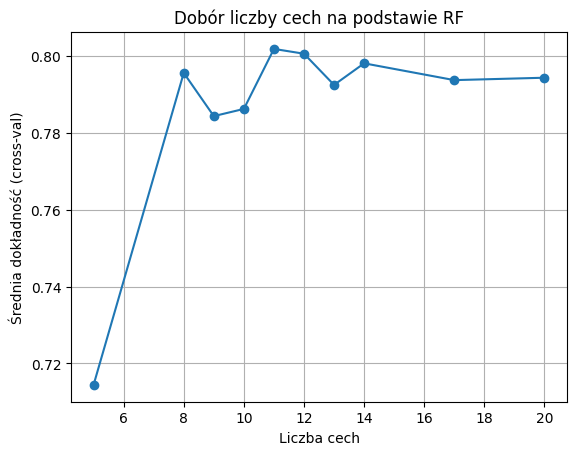

Accuracy from advanced classification: 0.8375


In [141]:
process_data(file)